A Simple RNN Task: 利用RNN的二元分类网络区分不同函数

In [198]:
%pip install torch numpy matplotlib 
# restart kernel after installation

Note: you may need to restart the kernel to use updated packages.


In [199]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [200]:
DATA_SIZE = 1000

sine_data_size = np.random.randint(int(0.3 * DATA_SIZE), int(0.7 * DATA_SIZE))
sigmoid_data_size = DATA_SIZE - sine_data_size

steps = np.arange(0, 10, 0.5)

# generate sine-like function samples
sine_init = np.random.uniform(-3, 3, (sine_data_size, 2))  # randomize a and b for sin(ax+b)
sine_data = np.sin(sine_init[:, :1] * steps + sine_init[:, 1:])

# generate sigmoid-like function samples
sigmoid_init = np.random.uniform(-3, 3, (sigmoid_data_size, 2)) # randomize a and b for 1/(1+e^(-ax+b))
sigmoid_data = 1 / (1 + np.exp(0 - sigmoid_init[:, :1] * steps + sigmoid_init[:, 1:]))

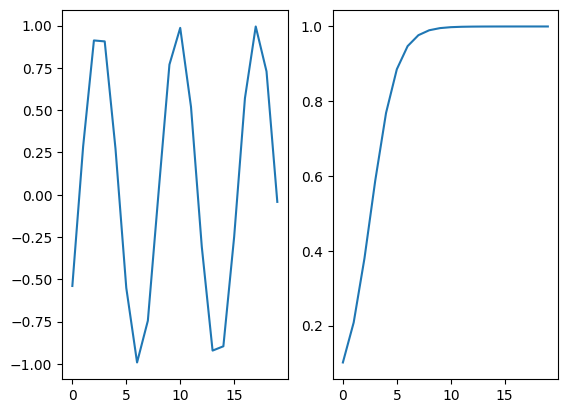

In [201]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(sine_data[0])
axs[1].plot(sigmoid_data[1])

In [202]:
# mix data
sine_data = np.concatenate((sine_data, np.ones((sine_data_size, 1))), axis=1)
sigmoid_data = np.concatenate((sigmoid_data, np.zeros((sigmoid_data_size, 1))), axis=1)
data = np.concatenate((sine_data, sigmoid_data), axis=0)
data = torch.Tensor(data)

In [203]:
# split two datasets

from torch.utils.data import random_split
train_set, test_set = random_split(data, [0.8, 0.2])


In [204]:
# define network

class SimpleClassificationRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleClassificationRNN, self).__init__()
        '''
        task 1: write network structure here using nn.RNN
        '''
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, seq, hc=None):
        '''
        task 2: write forward process
        '''
        out, hc = self.rnn(seq, hc)
        out = self.fc(out[:, -1, :])
        return out, hc

In [205]:
hidden_size = 16
learning_rate = 0.01

model = SimpleClassificationRNN(hidden_size)

'''
task 3: select appropriate criterion and optimizer
'''
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)


SimpleClassificationRNN(
  (rnn): RNN(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [206]:
def cal_accuracy(preds, true_values):
    preds = torch.where(preds>0.5, 1, 0)
    acc = torch.sum(1-torch.abs(preds-true_values)) / preds.shape[0]
    return acc

In [207]:
# training ...

epochs = 500
loss_log = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_set[:][:, :-1, np.newaxis])
    loss = criterion(output.view(-1), train_set[:][:, -1])
    acc = cal_accuracy(output.view(-1), train_set[:][:, -1])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {} acc {}".format(epoch, loss.item(), acc))

Epoch 0: loss 0.6676484942436218 acc 0.39125001430511475
Epoch 10: loss 0.572253942489624 acc 0.7037500143051147
Epoch 20: loss 0.4913896918296814 acc 0.768750011920929
Epoch 30: loss 0.45321643352508545 acc 0.8349999785423279
Epoch 40: loss 0.4135042130947113 acc 0.8637499809265137
Epoch 50: loss 0.33494776487350464 acc 0.8849999904632568
Epoch 60: loss 0.2218095362186432 acc 0.925000011920929
Epoch 70: loss 0.2861364781856537 acc 0.9175000190734863
Epoch 80: loss 0.2519104480743408 acc 0.9300000071525574
Epoch 90: loss 0.19853883981704712 acc 0.9300000071525574
Epoch 100: loss 0.673632800579071 acc 0.8174999952316284
Epoch 110: loss 0.5189674496650696 acc 0.7887499928474426
Epoch 120: loss 0.4959140121936798 acc 0.8149999976158142
Epoch 130: loss 0.4678187072277069 acc 0.8237500190734863
Epoch 140: loss 0.43972453474998474 acc 0.8337500095367432
Epoch 150: loss 0.4351825714111328 acc 0.8349999785423279
Epoch 160: loss 0.4293517768383026 acc 0.8362500071525574
Epoch 170: loss 0.419245

In [208]:
# performance on test set

output, _ = model(test_set[:][:, :-1, np.newaxis])
loss = criterion(output.view(-1), test_set[:][:, -1])
acc = cal_accuracy(output.view(-1), test_set[:][:, -1])

print("Test set: loss {} acc {}".format(loss.item(), acc))

Test set: loss 0.16205637156963348 acc 0.925000011920929


## Example Solution

In [209]:
# define network

class SimpleClassificationRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleClassificationRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=1)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, seq, hc=None):
        tmp, hc = self.rnn(seq, hc)
        out = torch.sigmoid(self.linear(hc[-1, ... ,:]))
        return out, hc

In [210]:
hidden_size = 16
learning_rate = 0.01

model = SimpleClassificationRNN(hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# you can also test other optimizers and learning_rate settings ...

In [211]:
def cal_accuracy(preds, true_values):
    preds = torch.where(preds>0.5, 1, 0)
    acc = torch.sum(1-torch.abs(preds-true_values)) / preds.shape[0]
    return acc

# you can also implement other metrics like F1 ...

In [212]:
epochs = 500
loss_log = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_set[:][:, :-1, np.newaxis])
    loss = criterion(output.view(-1), train_set[:][:, -1])
    acc = cal_accuracy(output.view(-1), train_set[:][:, -1])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {} acc {}".format(epoch, loss.item(), acc))

# you can also implement early stopping here ...

Epoch 0: loss 0.6979873776435852 acc 0.39125001430511475
Epoch 10: loss 0.5678942799568176 acc 0.7549999952316284
Epoch 20: loss 0.4677930176258087 acc 0.824999988079071
Epoch 30: loss 0.44803836941719055 acc 0.8374999761581421
Epoch 40: loss 0.45594722032546997 acc 0.8324999809265137
Epoch 50: loss 0.49221745133399963 acc 0.8050000071525574
Epoch 60: loss 0.4273914694786072 acc 0.8462499976158142
Epoch 70: loss 0.4240458309650421 acc 0.8487499952316284
Epoch 80: loss 0.388435959815979 acc 0.8612499833106995
Epoch 90: loss 0.23616479337215424 acc 0.9375
Epoch 100: loss 0.09761396050453186 acc 0.9775000214576721
Epoch 110: loss 0.09945233166217804 acc 0.9825000166893005
Epoch 120: loss 0.08320847153663635 acc 0.9787499904632568
Epoch 130: loss 0.9203736186027527 acc 0.5674999952316284
Epoch 140: loss 0.48965880274772644 acc 0.793749988079071
Epoch 150: loss 0.4031134843826294 acc 0.8887500166893005
Epoch 160: loss 0.34114304184913635 acc 0.8812500238418579
Epoch 170: loss 0.275005429983

In [213]:
output, _ = model(test_set[:][:, :-1, np.newaxis])
loss = criterion(output.view(-1), test_set[:][:, -1])
acc = cal_accuracy(output.view(-1), test_set[:][:, -1])

print("Test set: loss {} acc {}".format(loss.item(), acc))

Test set: loss 0.08595003932714462 acc 0.9750000238418579
